# Building a ground truth to map objects by deep-learning
## Study area: Digimap aerial photography images of Bristol

Data structure : 

```
data
├── digimap-aerial/
│   ├── 2020-Bristol-_1853122
│      ├── gtif/
│         ├── st5674_rgb_250_07.tif
├── OS_OpenMap_Local/Tile_ST_Bristol
│   ├── ST_Building.shp
│   ├── ST_Building.shx
│   json/json_format_building
│   ├── ST_Building.geojson

Projects/geolabel-maker/data/
├── building_footprint_catagories_json_vectors.json



Not yet working - environment agency vertical photography:
├── Environment_Agency/Vertical_Photography/bristol/2009/tif_tiles
│   ├── Ortho_IRRGB_P00021599_20090210_20090210_20cm_res.tif
│   ├── Ortho_IRRGB_P00021601_20090210_20090210_20cm_res.tif
├── Environment_Agency/Vertical_Photography/bristol/2012/tif_tiles
│   ├── Ortho_IRRGB_P00047302_20121125_20121125_25cm_res.tif
│   ├── Ortho_IRRGB_P00047304_20121125_20121125_25cm_res.tif

```






-----------------------------------

Original notebook

L'objectif de ce notebook est de vous guider dans la construction d'un jeu de données **(images, labels)**, pouvant servir de vérité terrain à un modèle de deep-learning pour la détection d'objets dans des photographies aériennes ou satellitaires. Ce jeu de données est créé à partir d'images géolocalisées (*fichiers rasters*) et de fichiers de géométries (*fichiers vecteurs*). 

Les données utilisées dans ce notebook sont sous license ouverte et proviennent de la plateforme des données de la Métropole de Lyon :
- [orthophotographies 2018](https://data.grandlyon.com/jeux-de-donnees/orthophotographie-2018-metropole-lyon-format-tiff/donnees)
- [emprise des bâtiments](https://data.grandlyon.com/jeux-de-donnees/batiments-metropole-lyon/ressources)
- [parcs et jardins](https://data.grandlyon.com/jeux-de-donnees/parcs-jardins-commune-lyon-v1-0-0/donnees)


Structure de nos données de départ : 

```
data
├── rasters
│   ├── 1843_5174_08_CC46.tif
│   ├── 1844_5173_08_CC46.tif
├── vectors
│   ├── buildings.json
│   ├── vegetation.json
├── categories.json
```

Les étapes nécessaires à la construction de cette vérité terrain correspondent aux fonction disponibles dans le module **`geolabels`** de notre bibliothèque [`geolabel_maker`]() : 

**1. Création des labels à partir des fichiers de géométries** :-> `make_labels()`

**2. Création des fichiers vrt** :-> `make_rasters()`

**3. Création de vignettes 256x256 pixels** :-> `make_tiles()`

**4. Création du fichier d'annotations** :-> `make_annotations()`

In [3]:
# Import des modules de geolabel_maker
from geolabel_maker import geolabels
from geolabel_maker.labels import show

In [2]:
# Import des autres librairies utilisées
from pathlib import Path 
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from shapely.geometry import box
import geopandas as gpd

In [3]:
# Definition des variables
#dir_rasters = "../../../data/Environment_Agency/Vertical_Photography/bristol/2009/tif_tiles" # Dossier où se trouvent les fichiers tif de l'orthophotographie de Lyon
#dir_rasters = "../../../data/Environment_Agency/Vertical_Photography/bristol/2012/tif_tiles" # Dossier où se trouvent les fichiers tif de l'orthophotographie de Lyon
# dir_rasters = "../../../data/digimap-aerial/2020-Bristol-_1853122/jpeg"
# # dir_rasters = "../../../data/digimap-aerial/2020-Bristol-_1853122/all"
# dir_rasters = "../../../data/digimap-aerial/2020-Bristol-_1853122/tif"
dir_rasters = "../../../data/digimap-aerial/2020-Bristol-_1853122/gtif"

# dir_vectors = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol/shapefile" # shapefile
dir_vectors = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol/json" # json

## 0. Visualisation des données

Avant de préparer nos données pour les algorithmes de deep-learning, commençons par en visualiser le contenu.

### Visualisation des images

Pour visualiser les photographies à notre disposition, nous utilisons simplement la bibliothèque de gestion d'images de Python ([PIL](https://he-arc.github.io/livre-python/pillow/index.html)) et la fonction `imshow()` de Matplotlib.

In [4]:
# Liste des fichiers images à notre disposition
rasters = list(Path(dir_rasters).iterdir())

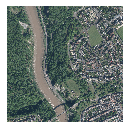

In [5]:
# Visualisation des images
figure= plt.figure(figsize=(12,6))    
columns = 5

for i, raster_file in enumerate(rasters):
    image = Image.open(raster_file)
    plt.subplot(len(rasters) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

On peut aussi accéder aux caractéristiques spatiales des images avec la bibliothèque [rasterio](https://rasterio.readthedocs.io/en/latest/). Ici, nous sauvegardons les emprises spatiales des images pour les visualiser en même temps que les géométries dont nous disposons. 

In [6]:
# Sauvegarde de l'emprise spatiale des images
rasters_xy = []
for raster_file in rasters :
    raster_data = rasterio.open(raster_file)
    coordinate = raster_data.bounds
    raster_bbox = box(*coordinate)
    rasters_xy.append(raster_bbox.exterior.xy)

### Visualisation des géométries

Pour visualiser les géométries, nous utilisons [geopandas](https://geopandas.org/index.html), une bibliothèque de gestion de données spatiales vectorielles. Le contenu de chaque fichier sera représenté par une couleur que nous définissons ci-dessus. La liste `colors` doit contenir autant de couleurs qu'il n'y a de fichiers dans le dossier `data/vectors/`.

In [7]:
# Définition des couleurs à utiliser pour représenter les différents types de données
# gris --> 1er fichier = bâtiments
# vert --> 2d fichier = végétation
colors = ["#92a9a2", "green"]

In [8]:
# Liste des fichiers de géométries à notre disposition
vectors = Path(dir_vectors).iterdir()

In [9]:
dir_vectors = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol"
# vector_file = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol/shapefile/ST_Building.shp" # shapefile
vector_file = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol/json/ST_Building.geojson" # geojson

vector_data = gpd.read_file(vector_file)

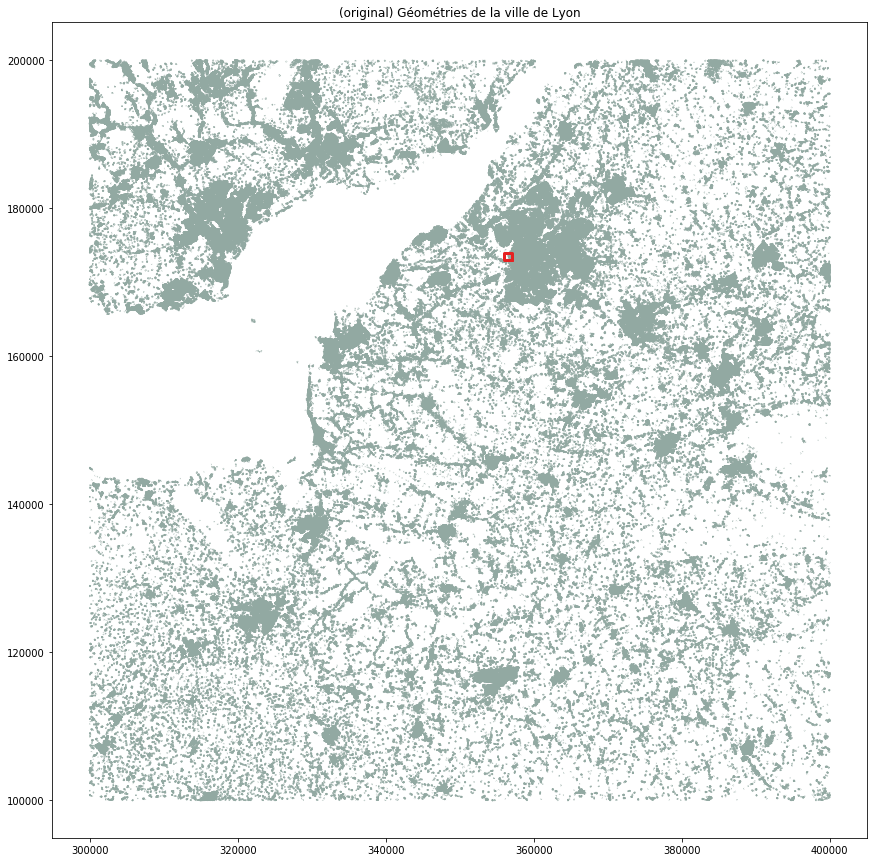

In [10]:
# Visualisation des fichiers vecteurs.
fig,ax=plt.subplots(figsize=(15,15))

for vector_file, color in zip(vectors, colors) :
    # Lecture du fichier vecteur
    vector_data = gpd.read_file(vector_file)    
    # Conversion du systeme de coordonnées pour que toutes les géométries 
    # soient dans le même système que les coordonnées des images.
    vector_data = vector_data.to_crs(raster_data.crs)
    vector_data.plot(color=color, alpha=0.7, ax=ax)
    vector_data.boundary.plot(edgecolor=color, ax=ax)

# Les emprises des images sont représentées par un carré rouge.
for x,y in rasters_xy :
    ax.plot(x, y, color='#e52222',
        linewidth=3, solid_capstyle='round')
    
plt.title("(original) Géométries de la ville de Lyon")
plt.show()

## 1. Création des labels à partir des fichiers de géométries

From the data that we have just represented, we will first of all create “label” images containing the representation of the geometries we have available and the extent of which corresponds to each available image file.

For that, we will specify the geometry files that we want to use, the name of the category of objects to which they correspond, as well as their color of representation in a configuration json file. This file must follow the following structure: :
```
{
  "name_of_category": {
    "id": 1,
    "file": path to your categorie_1 file,
    "color": [255, 255, 255]
  },
}
```
It consists of one information block per file / object category. Within these blocks, each information must be unique, in particular the identifier (id) and the RGB triplet (color) indicating the color to be used.

In [11]:
# Définition de la variable contenant le chemin du fichier json à utiliser

#categories_file = '../data/building_footprint_catagories_shapefile_vectors.json' #shapefile format - doesn't work
categories_file = '../data/building_footprint_catagories_json_vectors.json' #json format


Les images "labels" sont créées en appelant la fonction `make_labels()`.

In [12]:
import rasterio
#src = rasterio.open('../../../data/Environment_Agency/Vertical_Photography/bristol/2009/tif_tiles/Ortho_IRRGB_P00021599_20090210_20090210_20cm_res.tif')
src = rasterio.open("../../../data/digimap-aerial/2020-Bristol-_1853122/jpeg/st5974_rgb_250_07.jpg")

array = src.read()
array.shape

/home/ot19968/anaconda3/envs/geolabel-maker/lib/python3.6/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(3, 4000, 4000)

In [13]:
# makelabels debug
# geolabels.make_labels(dir_rasters, categories_file)

import json

from geolabel_maker import labels

#----------------

categories = categories_file

## hardcoding 2009 (trimmed tif path to trial)
dir_img = dir_rasters
# dir_img = "../../../data/Environment_Agency/Vertical_Photography/bristol/2009/tif_tiles"

#---------------

print("MAKE LABELS")
# Read json file
with open(categories) as json_file:
    categories_dict = json.load(json_file)

# List images
img_path = Path(dir_img)
rasters = [f for f in img_path.iterdir()]

print(rasters)

# Create the label image associated to the merged raster
# try:
#     for raster in rasters:
#         output_label = labels.make_label(str(raster), categories_dict)
#         print(f"Created label : {output_label}")
# except ValueError:
#     print("Please check your configuration file.")
    
# remove 4th raster dimension to prevent following error
# ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (1,5000,5000,4)
#[:,:,:3]
    
# outside try
for raster in rasters:
    output_label = labels.make_label(str(raster), categories_dict)
    print(f"Created label : {output_label}")

MAKE LABELS
[PosixPath('../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07.tif')]
Created label : ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07-label.tif


In [14]:
path_label = geolabels.make_labels(dir_rasters, categories_file)

MAKE LABELS
Created label : ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07-label.tif
Created label : ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07-label-label.tif


### Visualise Bristol labels resuts
Visualise using the function `show()` from the module `labels`


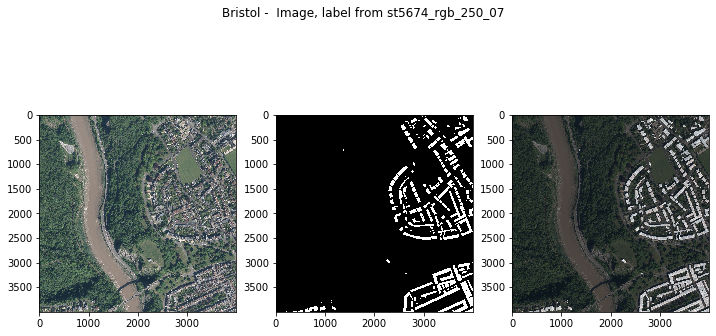

In [6]:
#visualisation of results
show(
    '../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07.tif',
    '../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07-label.tif',
    img_size=12500, title="Bristol - ", 
    show=True, save=False
)


It is possible to obtain a more precise visualization by reducing the size (in pixels) of the area being compared. The part of the selected image is then chosen randomly each time the function is called.

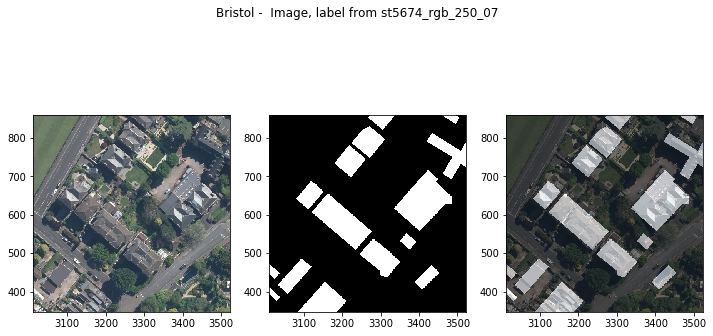

In [12]:
#visualisation of results
show(
    '../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07.tif',
    '../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07-label.tif',
    img_size=512, title="Bristol - ", 
    show=True, save=False
)

## 2. Creation of vrt files

The images and labels must then be grouped together in a VRT file to allow splitting into thumbnails. This step is performed with the make_rasters () function.

In [17]:
images_vrt, labels_vrt = geolabels.make_rasters(dir_rasters)

MAKE VIRTUAL RASTERS
1 images are merged in the file ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/images.vrt.
2 labels are merged in the file ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/labels.vrt.


These groupings can be visualized directly with the functions of the `rasterio` library.

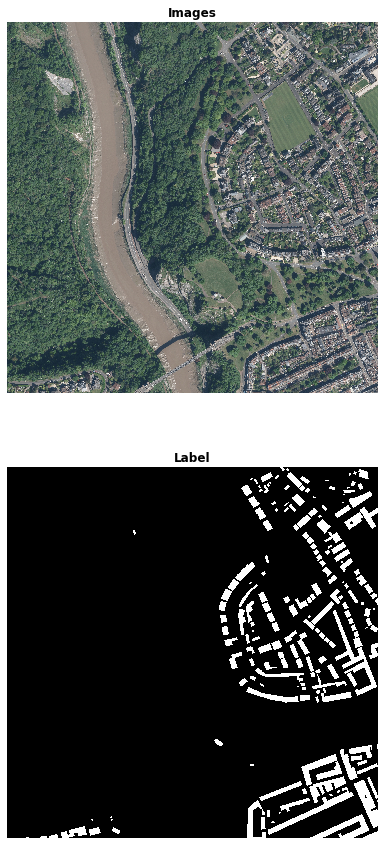

In [18]:
raster_images_vrt = rasterio.open(images_vrt)
raster_labels_vrt = rasterio.open(labels_vrt)

fig, (ax_img, ax_label) = plt.subplots(2,1, figsize=(15,15))

rasterio.plot.show(raster_images_vrt, title="Images", ax=ax_img)
ax_img.axis('off')
rasterio.plot.show(raster_labels_vrt, title="Label", ax=ax_label)
ax_label.axis('off')

raster_images_vrt.close()
raster_labels_vrt.close()

## 3. Create 256x256 pixels thumbnails

We can now split the images and labels we have into thumbnails of 256x256 pixels. For this, we create raster tiles at different zoom levels.

Before starting this step, it is necessary to create a directory where the thumbnails will be stored.

In [19]:
dir_tiles = '../data/building_footprint_tiles'

This step is performed with the `make_tiles ()` function.

In [20]:
geolabels.make_tiles(images_vrt, labels_vrt, dir_tiles)

MAKE TILES
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100
The image tiles are created in the folder ../data/building_footprint_tiles/images.
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100
The label tiles are created in the folder ../data/building_footprint_tiles/labels.


The tiles are organized in the `images` and` labels` directories, and visible in a web browser thanks to the `openlayers.html` files.

Structure of the data created:

```
data
├── digimap-aerial/
│   ├── 2020-Bristol-_1853122
│      ├── gtif/
│         ├── st5674_rgb_250_07.tif
├── OS_OpenMap_Local/Tile_ST_Bristol
│   ├── ST_Building.shp
│   ├── ST_Building.shx
│   json/json_format_building
│   ├── ST_Building.geojson

Projects/geolabel-maker/data/
├── building_footprint_catagories_json_vectors.json

Projects/geolabel-maker/data/tiles/
│   ├── images
│   |    ├── 13
│   |    |   ├── 4206
│   |    |   |   ├── 5269.png
│   |    ├── 14
│   |    ├── openlayers.html
│   |    ├── tilemapresource.xml
│   ├── labels
│   |    ├── 13
│   |    |   ├── 4206
│   |    |   |   ├── 5269.png
│   |    ├── 14
│   |    ├── openlayers.html
│   |    ├── tilemapresource.xml

```

## 4. Creation of the annotations file

Finally, for some models, it is necessary to provide a descriptive file complementary to the data set. The `make_annotations ()` function generates a json file in [COCO] (http://cocodataset.org/#home) format.

In [21]:
geolabels.make_annotations(dir_tiles, categories_file, '15')

MAKE ANNOTATIONS
../data/building_footprint_tiles/labels/15/16144/21865.png
../data/building_footprint_tiles/labels/15/16144/21864.png
../data/building_footprint_tiles/labels/15/16145/21865.png
../data/building_footprint_tiles/labels/15/16145/21864.png
The file annotations.json contains your annotations.


To check this file, we suggest you use the [Check_coco_annotations.ipynb] () notebook.